In [1]:
import typing as ty
import random
import math
import json
import gzip
from pathlib import Path
import itertools as it
import operator as op

import more_itertools as mit
import plotly.express as px
import numpy as np
import numpy.typing as npt
import torch


Set device to be run on

In [2]:
# torch.set_num_threads(4) ## For when Jacan's running it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


In [3]:
def data_iter(path: Path) -> ty.Iterator[ty.Dict[str, ty.Any]]:
    with gzip.open(path, "rt") as f:
        data_list = json.load(f)
        random.shuffle(data_list)
        for data_dict in data_list:
            yield data_dict

# Data pipeline

Here we define `bin_power()`, which effectively just splits the frequency axis into equal sized, contiguous bins, and then adds the powers of all the measurements which fall into that bin. This routine provides a way of changing the resolution of the signal to match the size of the input layer.

We also define `example_loader()`, which is a _generator function_, that can be iterated to create labelled training examples to be passed to the model and loss functions.

Note: the synthetic data generated in this notebook is actually sine waves in real space, not frequency space, but it should work the same either way. This choice was just made for quick prototyping.

In [14]:
def bin_power(
    freqs: npt.NDArray[np.float64],
    powers: npt.NDArray[np.float64],
    num_bins: int,
    freq_range: ty.Tuple[float, float],
) -> npt.NDArray[np.float64]:
    """Bins power spectrum with frequency.

    Parameters
    ----------
    freqs : ndarray[float64]
        Frequency values (x-axis).
    powers : ndarray[float64]
        Power values for given frequency (y-axis).
    num_bins : int
        Number of values to downsample the power spectrum to.
    freq_range : tuple[float, float]
        Range of values for the frequency (x-axis).

    Returns
    -------
    ndarray[float64]
        Bin-summed frequency spectrum.
    """
    freq_bins = np.linspace(*freq_range, num_bins + 1)
    signal = np.zeros(num_bins, dtype=np.float64)
    idxs = np.digitize(freqs, freq_bins, right=True) - 1
    np.add.at(signal, idxs, powers)
    return signal, freq_bins


def example_loader(
    dict_iter: ty.Iterator[ty.Dict[str, ty.Any]], resolution: int,
) -> ty.Iterator[ty.Tuple[torch.Tensor, torch.Tensor, npt.NDArray[np.float64]]]:
    """Provides samples from our training set of input data,
    and the target.

    Notes
    -----
    This is where the data is read from file, and provided
    for use in the training loop.
    You should should extend this function to shuffle the
    data training example ordering.
    """
    freq_range = (0.0, 25.0)
    for data_dict in dict_iter:
        freqs = np.array(data_dict.pop("frequency"), dtype=np.float64)
        power = np.array(data_dict.pop("power"), dtype=np.float64)
        power = np.nan_to_num(power, copy=False)
        # power /= power.sum()
        target_val = int(data_dict.pop("target"))
        signal, bins = bin_power(freqs, power, resolution, freq_range)
        signal = torch.from_numpy(signal)
        target = torch.zeros(2, dtype=torch.float64)
        target[target_val] = 1
        # For running on GPU
        signal = signal.cuda()
        target = target.cuda()
        yield signal, target, bins


# LoaderElement = ty.Tuple[torch.Tensor, torch.Tensor, np.ndarray]


# def batch_examples(loader: ty.Iterable[LoaderElement], batch_size: int) -> ty.Iterator[LoaderElement]:
#     for chunk in mit.chunked(loader, batch_size):
#         signals, targets, bin_batch = zip(*chunk)
#         signal

In [5]:
tuple(map(lambda x: torch.any(torch.isnan(x)).item(), signals)).index(True, 25)

NameError: name 'signals' is not defined

In [6]:
json_data = data_iter("./DATA/jsons/training_data.json.gz")

In [7]:
foo = tuple(it.islice(json_data, 40))

In [8]:
data_dict = foo[31]
freqs = np.array(data_dict.pop("frequency"), dtype=np.float64)
power = np.array(data_dict.pop("power"), dtype=np.float64)

# Model and optimization definitions

Here we provide constructor functions, which create the model (a very simple 2 layer MLP), along with the loss and optimizer.

In [9]:
ModelType = torch.nn.Module
OptimType = torch.optim.Optimizer
LossType = torch.nn.modules.loss._WeightedLoss


def model_init(
    in_dim: int, hidden_dim: int, out_dim: int, depth: int,
) -> ModelType:
    model = torch.nn.Sequential(
        torch.nn.Linear(in_dim, hidden_dim),
        torch.nn.Dropout(p=0.2),
    )
    for i in range(depth):
        model.append(torch.nn.PReLU())
        model.append(torch.nn.Linear(hidden_dim, hidden_dim if (i + 1) < depth else out_dim))
    model.append(torch.nn.Softmax(-1))
    model.to(device) # Added for running on GPU
    return model.to(torch.float64)


def optim_init(
    model: ModelType, lr: float, weight_decay: float
) -> ty.Tuple[OptimType, LossType]:
    return (
        torch.optim.SGD(
            model.parameters(),
            lr=lr,
            momentum=0.3,
            weight_decay=weight_decay,
        ),
        torch.nn.CrossEntropyLoss(),
    )

# Training loop

This routine runs a single epoch of a training loop. It is to be passed the results of the model and optimizer constructor functions, along with the dataloader generator. Additionally, `interval` controls how many examples to calculate the accuracy over, and `converge_limit` sets the number of consecutive perfect accuracy scores to require before exiting the training loop. If this is not met, the model will keep training until the dataloader is exhausted.

In [10]:
def train(
    model: ModelType,
    optim: OptimType,
    criterion: LossType,
    dataloader: ty.Iterator[ty.Tuple[torch.Tensor, torch.Tensor, npt.NDArray[np.float64]]],
    interval: int = 100,
    converge_limit: ty.Optional[int] = 10,
) -> ModelType:
    num_correct = 0
    converge_count = 0
    model.train()
    for i, (signal, target, _) in enumerate(dataloader):
        optim.zero_grad()
        pred = model(signal)
        if torch.argmax(pred) == torch.argmax(target):
            num_correct += 1
        loss = criterion(pred, target)
        if (i % interval == 0) and (i != 0):
            acc = num_correct / interval
            print(f"training step: {i:07d}, loss: {loss.item():.5f}, accuracy: {acc:.5f}")
            num_correct = 0
            if math.isclose(acc, 1.0):
                converge_count += 1
            else:
                converge_count = 0
            if (converge_limit is not None) and (converge_count == converge_limit):
                break
        loss.backward()
        optim.step()
    return model

# Defining and training the model

We pass in the model and optimizer hyperparameters, initialise the dataloader, and then run the training loop. The model is returned from the training loop for later evaluation.

In [15]:
in_dim, hidden_dim, out_dim = 1024, 128, 2
model = model_init(in_dim, hidden_dim, out_dim, 40) # originally 20
optim, criterion = optim_init(model, 1.0e-4, 1.0e-2)
for epoch in range(20): # Originally 20
    print(f"{epoch=}")
    dataloader = example_loader(data_iter("DATA/jsons/training_data.json.gz"), in_dim)
    model = train(model, optim, criterion, dataloader, interval=100, converge_limit=None)

epoch=0
training step: 0000100, loss: 0.68631, accuracy: 0.97000
training step: 0000200, loss: 0.68404, accuracy: 0.91000
training step: 0000300, loss: 0.68201, accuracy: 0.87000
training step: 0000400, loss: 0.70660, accuracy: 0.88000
training step: 0000500, loss: 0.67765, accuracy: 0.92000
training step: 0000600, loss: 0.67577, accuracy: 0.85000
training step: 0000700, loss: 0.71307, accuracy: 0.89000
training step: 0000800, loss: 0.67148, accuracy: 0.91000
training step: 0000900, loss: 0.66941, accuracy: 0.89000
training step: 0001000, loss: 0.66741, accuracy: 0.88000
training step: 0001100, loss: 0.66542, accuracy: 0.88000
training step: 0001200, loss: 0.66333, accuracy: 0.90000
training step: 0001300, loss: 0.66152, accuracy: 0.85000
training step: 0001400, loss: 0.65945, accuracy: 0.90000
training step: 0001500, loss: 0.73018, accuracy: 0.88000
training step: 0001600, loss: 0.65570, accuracy: 0.85000
training step: 0001700, loss: 0.65373, accuracy: 0.89000
training step: 0001800,

training step: 0001300, loss: 0.95070, accuracy: 0.79000
training step: 0001400, loss: 0.48776, accuracy: 0.88000
training step: 0001500, loss: 0.48705, accuracy: 0.86000
training step: 0001600, loss: 0.48621, accuracy: 0.90000
training step: 0001700, loss: 0.48534, accuracy: 0.91000
training step: 0001800, loss: 0.48451, accuracy: 0.90000
training step: 0001900, loss: 0.48375, accuracy: 0.88000
training step: 0002000, loss: 0.48305, accuracy: 0.86000
training step: 0002100, loss: 0.48224, accuracy: 0.90000
training step: 0002200, loss: 0.48134, accuracy: 0.93000
training step: 0002300, loss: 0.48058, accuracy: 0.88000
training step: 0002400, loss: 0.47986, accuracy: 0.88000
training step: 0002500, loss: 0.47915, accuracy: 0.87000
training step: 0002600, loss: 0.47839, accuracy: 0.89000
training step: 0002700, loss: 0.47760, accuracy: 0.90000
training step: 0002800, loss: 0.47691, accuracy: 0.87000
training step: 0002900, loss: 0.47620, accuracy: 0.88000
training step: 0003000, loss: 0

training step: 0002500, loss: 1.08875, accuracy: 0.87000
training step: 0002600, loss: 0.41000, accuracy: 0.95000
training step: 0002700, loss: 0.40972, accuracy: 0.85000
training step: 0002800, loss: 0.40938, accuracy: 0.89000
training step: 0002900, loss: 0.40911, accuracy: 0.85000
training step: 0003000, loss: 0.40871, accuracy: 0.93000
training step: 0003100, loss: 0.40848, accuracy: 0.82000
training step: 0003200, loss: 0.40808, accuracy: 0.93000
training step: 0003300, loss: 1.09406, accuracy: 0.88000
epoch=9
training step: 0000100, loss: 0.40739, accuracy: 0.86000
training step: 0000200, loss: 0.40703, accuracy: 0.91000
training step: 0000300, loss: 0.40669, accuracy: 0.90000
training step: 0000400, loss: 0.40635, accuracy: 0.90000
training step: 0000500, loss: 0.40599, accuracy: 0.91000
training step: 0000600, loss: 0.40579, accuracy: 0.81000
training step: 0000700, loss: 0.40553, accuracy: 0.86000
training step: 0000800, loss: 0.40527, accuracy: 0.85000
training step: 0000900,

training step: 0000300, loss: 0.37602, accuracy: 0.87000
training step: 0000400, loss: 0.37589, accuracy: 0.85000
training step: 0000500, loss: 0.37577, accuracy: 0.84000
training step: 0000600, loss: 1.16110, accuracy: 0.85000
training step: 0000700, loss: 0.37550, accuracy: 0.86000
training step: 0000800, loss: 0.37536, accuracy: 0.86000
training step: 0000900, loss: 0.37525, accuracy: 0.84000
training step: 0001000, loss: 0.37510, accuracy: 0.87000
training step: 0001100, loss: 0.37495, accuracy: 0.87000
training step: 0001200, loss: 0.37479, accuracy: 0.89000
training step: 0001300, loss: 1.16331, accuracy: 0.89000
training step: 0001400, loss: 0.37443, accuracy: 0.93000
training step: 0001500, loss: 0.37423, accuracy: 0.93000
training step: 0001600, loss: 0.37408, accuracy: 0.88000
training step: 0001700, loss: 0.37392, accuracy: 0.89000
training step: 0001800, loss: 0.37375, accuracy: 0.91000
training step: 0001900, loss: 0.37359, accuracy: 0.89000
training step: 0002000, loss: 1

training step: 0001500, loss: 0.35841, accuracy: 0.82000
training step: 0001600, loss: 0.35833, accuracy: 0.87000
training step: 0001700, loss: 0.35824, accuracy: 0.89000
training step: 0001800, loss: 0.35815, accuracy: 0.88000
training step: 0001900, loss: 1.20082, accuracy: 0.93000
training step: 0002000, loss: 0.35794, accuracy: 0.90000
training step: 0002100, loss: 0.35782, accuracy: 0.93000
training step: 0002200, loss: 0.35773, accuracy: 0.89000
training step: 0002300, loss: 0.35764, accuracy: 0.88000
training step: 0002400, loss: 0.35756, accuracy: 0.88000
training step: 0002500, loss: 0.35748, accuracy: 0.88000
training step: 0002600, loss: 0.35736, accuracy: 0.93000
training step: 0002700, loss: 0.35724, accuracy: 0.94000
training step: 0002800, loss: 1.20282, accuracy: 0.85000
training step: 0002900, loss: 0.35710, accuracy: 0.86000
training step: 0003000, loss: 1.20317, accuracy: 0.88000
training step: 0003100, loss: 0.35694, accuracy: 0.89000
training step: 0003200, loss: 0

# Saving model

In [300]:
torch.save(model, "./model/trained_model.model")

# Model evaluation

Here we visualise some evaluation examples (that the model has not seen), and compare the prediction to the target.

Note: evaluation should be done using metrics like accuracy, confusion matrices, _etc._ over the whole validation set.  We look at one example at a time as a sanity check when prototyping, but this is only a preliminary step!

# Load model

In [301]:
model = torch.load("./model/trained_model.model")

In [16]:
model.eval()
dataloader = example_loader(data_iter("./DATA/jsons/training_data.json.gz"), in_dim)

In [20]:
signal, target, bins = next(dataloader)
pred = model(signal)
print(f"prediction: {torch.argmax(pred).item()}, target: {torch.argmax(target).item()}")
x = (bins[1:] + bins[:-1]) * 0.5  # get midpoints of bins
signal = signal.cpu()
y = signal.numpy()
px.line(x=x, y=y)

prediction: 0, target: 0


### Creating confusion matrix

In [16]:
signal, target, bins = next(dataloader)
preds = model(signal)
print(f"prediction: {torch.argmax(pred).item()}, target: {torch.argmax(target).item()}")

prediction: 0, target: 0


In [17]:
def confuse_me():
    all_my_preds = torch.tensor([])
    all_my_targets = torch.tensor([])
    for _ in dataloader:
        signal, target, bins = next(dataloader)
        preds = model(signal)
        all_my_preds   = torch.cat(all_my_preds, preds)
        all_my_targets = torch.cat(all_my_targets, target)
    print (preds)
        

tensor([[1492,    0],
        [ 181,    0]])


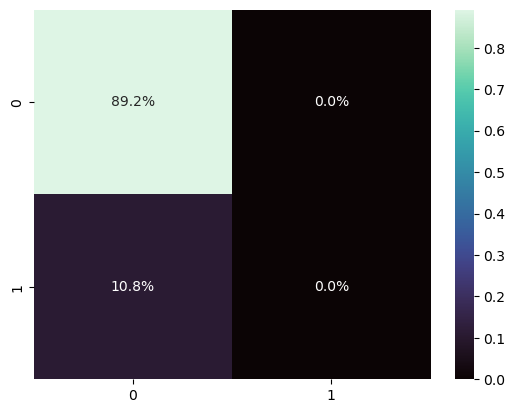

In [22]:
# Copied base for this from https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
# Modified for use here

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn


from torchmetrics import ConfusionMatrix

cf_preds = np.array([])
cf_targs = np.array([])

dataloader = example_loader(data_iter("./DATA/jsons/training_data.json.gz"), in_dim)

for _ in dataloader:
    signal, target, bins = next(dataloader)
    
    output = model(signal)
    
    output = torch.argmax(output).data.cpu()
    # output = output.type(torch.int64) # I don't think this is necessary, as it should already be int64
    cf_preds = np.append(cf_preds, output)
      
    #target = target.data.cpu()
    target = torch.argmax(target).data.cpu()
    #target = target.type(torch.int64)
    cf_targs = np.append(cf_targs, target) # Save Truth

# Now convert from nparray to torch
cf_preds = torch.as_tensor(cf_preds, dtype = torch.int64)
cf_targs = torch.as_tensor(cf_targs, dtype = torch.int64)


cf_matrix = ConfusionMatrix(task = "binary", num_classes =2)
cf_matrix = cf_matrix(cf_preds, cf_targs)
print(cf_matrix)

sn.heatmap(cf_matrix/torch.sum(cf_matrix), annot=True, fmt=".1%", cmap="mako")
plt.savefig("./model/heatmap.png")


In [293]:
torch.sum(cf_matrix)

tensor(1673)

In [106]:
cf_matrix(cf_preds, cf_targs)

tensor([[794,   0,   0,   0,   0],
        [202,   0,   0,   0,   0],
        [413,   0,   0,   0,   0],
        [243,   0,   0,   0,   0],
        [ 21,   0,   0,   0,   0]])

In [474]:
couuunt = 0
for _ in dataloader:
    couuunt +=1
print(couuunt)

3345
